In [1]:
!pip install -q segmentation_models

!pip show tensorflow


Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, gast, numpy, termcolor, wrapt, tensorflow-estimator, astor, protobuf, absl-py, wheel, google-pasta, keras-applications, opt-einsum, grpcio, tensorboard, keras-preprocessing
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
import keras
import zipfile
import cv2
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
import albumentations as albu

from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data

In [4]:
train_csv = "/content/drive/My Drive/Colab Notebooks/train.csv"
train_df = pd.read_csv(train_csv)
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()
print(train_df.shape)
train_df.head()

mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

sample_csv = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'
sub_df = pd.read_csv(sample_csv)
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

(22184, 5)
(5546, 2)


In [0]:
train_zip = '/content/drive/My Drive/Colab Notebooks/train_images.zip'
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("./train_images")

In [0]:
test_zip = '/content/drive/My Drive/Colab Notebooks/test_images.zip'
with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall("./test_images")

# Helper functions

In [0]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

# Loss functions and metrics

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


# Constants

In [0]:
# DATA_DIR='/Users/treziapov/Documents/JupyterNotebooks/cs230/train_images'
DATA_DIR='./train_images'

CLASSES = ['Fish', 'Flower', 'Gravel', 'Sugar']
NUM_CLASSES = len(CLASSES)

DIMS_3D = (320, 480, 3)
DIMS_2D = (DIMS_3D[0], DIMS_3D[1])
NUM_CHANNELS = DIMS_3D[2]

# BACKBONE = None
# BACKBONE = 'vgg16'
BACKBONE = 'resnet34'
# BACKBONE = 'resnext101'
# BACKBONE = 'efficientnetb3'

BATCH_SIZE = 16

EPOCHS = 30

OPTIMIZER = 'adam'

AUGMENT = True

# Sample test

In [0]:
sample_filename = '002be4f.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]
sample_path = f"./train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(1400, 2100))

fig, axs = plt.subplots(1, 5, figsize=(20, 12))
axs[0].imshow(sample_img)
axs[0].set_title("Input")
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].set_title(sample_image_df['ClassId'][sample_image_df.index[0]+i])
    axs[i+1].axis('off')


# Data Generator

In [0]:
class DataGenerator(keras.utils.Sequence):
# class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='./train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

# Training

In [0]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.2
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=True,
    n_channels=3,
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    reshape=(320, 480),
    augment=False,
    n_channels=3,
    n_classes=4
)

In [12]:
model = sm.FPN(BACKBONE, encoder_weights='imagenet', classes = NUM_CLASSES)
# model = sm.Unet(classes = NUM_CLASSES)
model.compile(
    'adam',
    loss = bce_dice_loss,
    metrics = [dice_coef, binary_crossentropy]
)













85524480/85521592 [==============================] - 2s 0us/step




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
print(model.metrics_names)

In [0]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit_generator(
    generator=train_generator,
    validation_data = val_generator,
    epochs=1,
    verbose=1
)


In [15]:
print("Backbone: " + BACKBONE)

baseCheckpointDir='/content/drive/My Drive/fpn_resnet34/'
checkpointPath = baseCheckpointDir + 'weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}-{val_dice_coef:.2f}-{dice_coef:.2f}.hdf5'

checkpoint = ModelCheckpoint(
    checkpointPath,
    monitor='val_dice_coef', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True,
    mode='max'
)

csvLogger = CSVLogger('training.log')

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, csvLogger],
    use_multiprocessing=False,
    workers=1,
    epochs=30
)

Backbone: resnet34


Epoch 1/30
554/554 [==============================] - 602s 1s/step - loss: 1.0786 - dice_coef: 0.3462 - binary_crossentropy: 0.4249 - val_loss: 1.2824 - val_dice_coef: 0.3717 - val_binary_crossentropy: 0.6541

Epoch 00001: val_dice_coef improved from -inf to 0.37168, saving model to /content/drive/My Drive/fpn_resnet34/weights.01-1.08-1.28-0.37-0.35.hdf5
Epoch 2/30
554/554 [==============================] - 554s 1s/step - loss: 1.0293 - dice_coef: 0.3760 - binary_crossentropy: 0.4053 - val_loss: 1.3746 - val_dice_coef: 0.3413 - val_binary_crossentropy: 0.7159

Epoch 00002: val_dice_coef did not improve from 0.37168
Epoch 3/30
554/554 [==============================] - 586s 1s/step - loss: 1.0188 - dice_coef: 0.3822 - binary_crossentropy: 0.4010 - val_loss: 1.6159 - val_dice_coef: 0.3249 - val_binary_crossentropy: 0.9408

Epoch 00003: val_dice_coef did not improve from 0.37168
Epoch 4/30
554/554 [==============================] - 593s 1s/step - loss: 1.0089 - dice_c

In [0]:
# Keep collab running
import time
while True:
  time.sleep(1000)

In [0]:
# Check GPU availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [0]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(tf.test.is_gpu_available())

In [0]:

baseCheckpointDir='/content/drive/My Drive/fpn_resnet34_'
with open(baseCheckpointDir+'history.json', 'w') as f:
    json.dump(str(history.history), f)

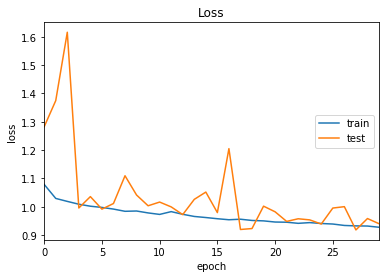

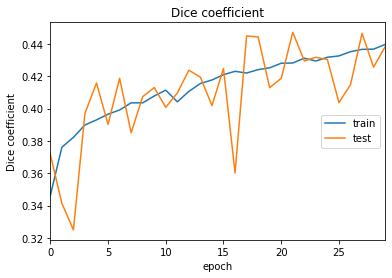

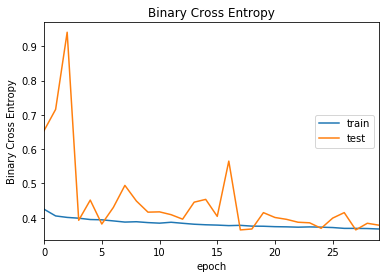

In [20]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.legend(['train','test'], loc='right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig(baseCheckpointDir+"loss.png")

history_df[['dice_coef', 'val_dice_coef']].plot()
plt.title('Dice coefficient')
plt.legend(['train','test'], loc='right')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.savefig(baseCheckpointDir+"dice.png")

history_df[['binary_crossentropy', 'val_binary_crossentropy']].plot()
plt.title('Binary Cross Entropy')
plt.legend(['train','test'], loc='right')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('epoch')
plt.savefig(baseCheckpointDir+"bce.png")

In [21]:
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(320, 480),
        n_channels=3,
        base_path='./test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    )

    for j, b in enumerate(batch_idx):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()

        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))

        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv(baseCheckpointDir+'submission.csv', index=False)

198/198 [==============================] - 13s 68ms/step
